# Spectral clustering

In [1]:
# imports
import os
import numpy as np
import matplotlib.pyplot as plt

random_state = 222

%matplotlib inline

In [2]:
# read the data from file
# data_path = 'viz/data-240.tsv'
# data_path = 'viz/data-5-80.tsv'
data_path = 'viz/data-3-30.tsv'
data_list = []
with open(data_path) as f:
    for r in f:
        data_list.append([float(x) for x in r.strip().split()])
        

In [3]:
data = np.array(data_list)

In [4]:
data.shape # 2 speakers in this matrix

(90, 256)

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculating the Cossine similarity
Construct the affinity matrix A, where $A_{ij}$ is the cosine similarity between $i^{th}$ and $j^{th}$ segment embedding when
$i \neq j$, <br> and the diagonal elements are set to the maximal value in each row:
<br>
$A_{ii} = max_{j \neq i} A_{ij}$

In [6]:
similarity = np.dot(data, data.T)

# squared magnitude of preference vectors (number of occurrences) (diagonals are ai*ai)
square_mag = np.diag(similarity)

# inverse squared magnitude
inv_square_mag = 1 / square_mag

# if it doesn't occur, set it's inverse magnitude to zero (instead of inf)
inv_square_mag[np.isinf(inv_square_mag)] = 0

# inverse of the magnitude
inv_mag = np.sqrt(inv_square_mag)

# cosine similarity (elementwise multiply by inverse magnitudes)
cosine = similarity * inv_mag
A =  cosine.T * inv_mag

In [7]:
# A.diagonal()

In [8]:
# np.min(A - A.T)

### Replace the diagonals by max of row, where i != j

In [9]:
# Fill the diagonals with very large negative value
np.fill_diagonal(A, -1000)
# Fill the diagonals with the max of each row
np.fill_diagonal(A, A.max(axis=1))

In [10]:
# A.diagonal()

We define cosine distance as $d(x, y) =(1−cos(x, y))/2$

In [11]:
A.min(), A.max()

(-0.5403370496847387, 0.9951558139833063)

In [12]:
np.arccos(-0.47102793534270815) * 180/np.pi # To calculate the similarity (in degree)

118.10104275021378

In [13]:
p = 50
np.arccos(np.percentile(A, p)) * 180/np.pi

86.45840653262516

In [14]:
A = (1-A)/2

In [15]:
A.min(), A.max()

(0.0024220930083468373, 0.7701685248423693)

**Matrix A is the required affinity matrix**

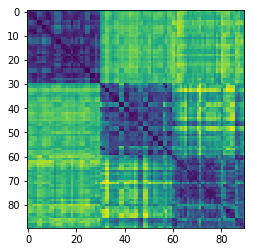

In [16]:
plt.imshow(A)
plt.show()

Apply the following sequence of refinement operations on the affinity matrix A:
1. Gaussian Blur with standard deviation $\sigma$
2. Row-wise  Thresholding:   For  each  row,  set  elements smaller than this row’s p-percentile to 0 (In practice, it’s better to use soft thresholding: scale these elements by a small multiplier such as 0.01)
3. Symmetrization: $Y_{ij} = max(X_{ij}, X_{ji})$
4. Diffusion: $Y = XX^T$
5. Row-wise Max Normalization: $Y_{ij} = X_{ij}/max_kX_{ik}$

## Applying Gaussian Blur with standard deviation $\sigma$

In [17]:
from scipy.ndimage.filters import gaussian_filter

In [18]:
# Standard deviation sigma, we may need to tune this
sigma = 1
A_gau = gaussian_filter(A, sigma)
sigma = 2
A_gau2 = gaussian_filter(A, sigma)
sigma = 0.5
A_gau4 = gaussian_filter(A, sigma)

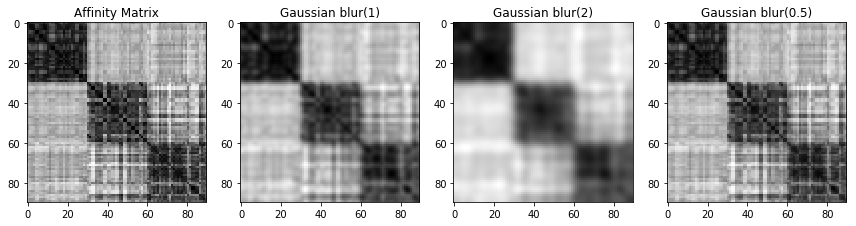

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))

ax[0].imshow(A, cmap='gray')
ax[0].set_title('Affinity Matrix')

ax[1].imshow(A_gau, cmap='gray')
ax[1].set_title('Gaussian blur(1)')

ax[2].imshow(A_gau2, cmap='gray')
ax[2].set_title('Gaussian blur(2)')

ax[3].imshow(A_gau4, cmap='gray')
ax[3].set_title('Gaussian blur(0.5)')

plt.tight_layout()
plt.show()

In [20]:
sigma = 0.5 # we will select sigma as 0.5
A_gau = gaussian_filter(A, sigma)

## Step 2: Thresholding

Row-wise Thresholding: For each row, set elements smaller than this row’s p-percentile to 0 (In practice, it’s better to use soft thresholding: scale these elements by a small multiplier such as 0.01)

#### Method 1: Using p-percentile (Setting p = 25th)

In [21]:
# p = 25 # This can be tuned
# P_row = np.percentile(A_gau, p, axis=1).reshape(1, A.shape[0])
# A_thresh = A_gau.copy() # Just to create copy, you can delete it later
# A_thresh[A_gau < P_row.T] = 0

#### Method 2: threshold = 0.01

In [22]:
# using multiplier = 0.01
threshold_multiplier = 0.01
A_thresh = A_gau * threshold_multiplier

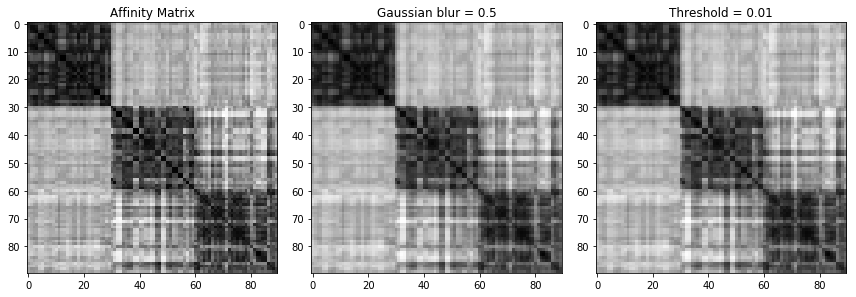

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

ax[0].imshow(A, cmap='gray')
ax[0].set_title('Affinity Matrix')

ax[1].imshow(A_gau, cmap='gray')
ax[1].set_title(f'Gaussian blur = {sigma}')

ax[2].imshow(A_thresh, cmap='gray')
ax[2].set_title(f'Threshold = {threshold_multiplier}')

plt.tight_layout()
plt.show()

### Symmetrization: $Y_{ij} = max(X_{ij}, X_{ji})$

In [24]:
A_sym = np.maximum(A_thresh, A_thresh.T)

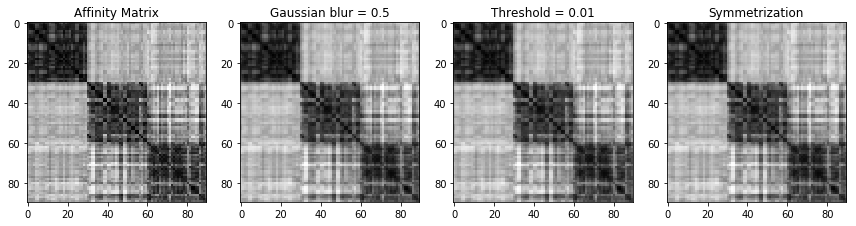

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))

ax[0].imshow(A, cmap='gray')
ax[0].set_title('Affinity Matrix')

ax[1].imshow(A_gau, cmap='gray')
ax[1].set_title(f'Gaussian blur = {sigma}')

ax[2].imshow(A_thresh, cmap='gray')
ax[2].set_title(f'Threshold = {threshold_multiplier}')

ax[3].imshow(A_sym, cmap='gray')
ax[3].set_title(f'Symmetrization')

plt.tight_layout()
plt.show()

### Diffusion: $Y = XX^T$

In [26]:
A_diffusion = A_sym * A_sym.T

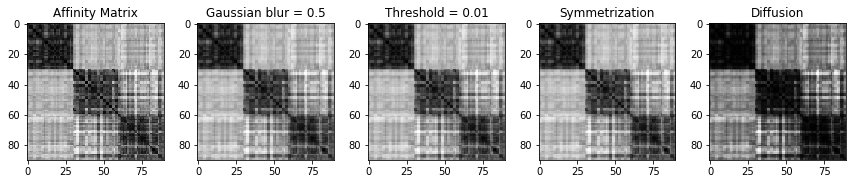

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))

ax[0].imshow(A, cmap='gray')
ax[0].set_title('Affinity Matrix')

ax[1].imshow(A_gau, cmap='gray')
ax[1].set_title(f'Gaussian blur = {sigma}')

ax[2].imshow(A_thresh, cmap='gray')
ax[2].set_title(f'Threshold = {threshold_multiplier}')

ax[3].imshow(A_sym, cmap='gray')
ax[3].set_title(f'Symmetrization')

ax[4].imshow(A_diffusion, cmap='gray')
ax[4].set_title(f'Diffusion')

plt.tight_layout()
plt.show()

### Row-wise Max Normalization: $Y_{ij} = X_{ij}/max_kX_{ik}$

In [28]:
Row_max = A_diffusion.max(axis=1).reshape(1, A_diffusion.shape[0])

In [29]:
Row_max.shape

(1, 90)

In [30]:
A_norm = A_diffusion / Row_max.T

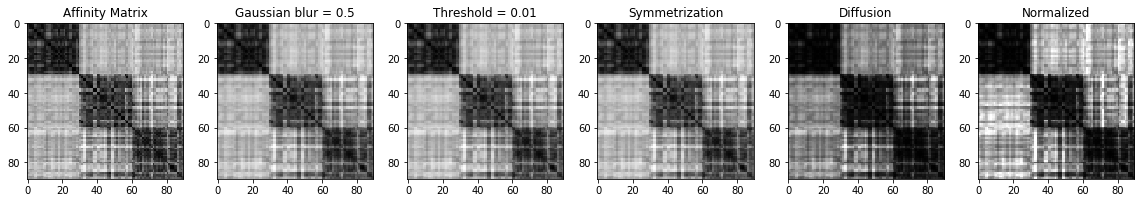

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(16, 4))

ax[0].imshow(A, cmap='gray')
ax[0].set_title('Affinity Matrix')

ax[1].imshow(A_gau, cmap='gray')
ax[1].set_title(f'Gaussian blur = {sigma}')

ax[2].imshow(A_thresh, cmap='gray')
ax[2].set_title(f'Threshold = {threshold_multiplier}')

ax[3].imshow(A_sym, cmap='gray')
ax[3].set_title(f'Symmetrization')

ax[4].imshow(A_diffusion, cmap='gray')
ax[4].set_title(f'Diffusion')

ax[5].imshow(A_norm, cmap='gray')
ax[5].set_title(f'Normalized')

plt.tight_layout()
plt.show()

# Step 4: Eigen Decomposition
After  all  refinement  operations  have  been  applied,  perform eigen-decomposition on the refined affinity matrix. Let the $n$
eigen-values be: $λ1> λ2> ··· > λn$. We use the maximal
eigen-gap to determine the number of clusters $k$ <br>
$k = arg max_{\substack{1 \leq k \leq n}} \frac{\lambda_{k}}{\lambda_{k + 1}}$


In [32]:
# A_norm.max()

In [33]:
eigval, eigvec = np.linalg.eig(A_norm)

In [34]:
# Since eigen values cannot be negative for Positive semi definite matrix, the numpy returns negative values, converting it to positive
eigval = np.abs(eigval)

**Reordering the eigen values**

In [35]:
sorted_eigval_idx = np.argsort(eigval)[::-1]
sorted_eigval = np.sort(eigval)[::-1]

In [36]:
# For division according to the equation
eigval_shifted = np.roll(sorted_eigval, -1)

Take the eigen values above a threshold of 0.1, due to eigen value calculations, some eigen values as low as $1*e^-5$ cause problems

In [37]:
eigval_thresh = 0.1
sorted_eigval = sorted_eigval[sorted_eigval > eigval_thresh]
eigval_shifted = eigval_shifted[:sorted_eigval.shape[0]]

In [38]:
sorted_eigval.shape

(36,)

**Note: Don't take the first value for calculations, if first value is large, following equation will return k=1, and we want more than one clusters**

In [39]:
# Get the argmax of the division, since its 0 indexed, add 1
k = np.argmax(sorted_eigval[1:]/eigval_shifted[1:]) + 2
print(f'Number of clusters: {k}')

Number of clusters: 3


In [40]:
# Get the indexes of eigen vectors
idexes = sorted_eigval_idx[:k]

In [41]:
A_eigvec = eigvec[:, idexes]

In [42]:
A_eigvec.shape

(90, 3)

In [43]:
# fig, ax = plt.subplots(1, 3, figsize=(16, 4))

# ax[0].scatter(A_eigvec[:,0], A_eigvec[:,1])
# ax[1].scatter(eigvec[:,1], eigvec[:,2])
# ax[2].scatter(eigvec[:,2], eigvec[:,3])
# ax[2].scatter(eigvec[:,3], eigvec[:,4])
# plt.show()

# K-Means offline clustering
Like in many diarization systems, we integrated the K-Means clustering algorithm with our system. Specifically, we use K-Means++ for initialization. To determine the number of speakers $k$,  we  use  the  “elbow”  of  the  derivatives  of  conditional  Mean Squared Cosine Distances 1 (MSCD) between each embedding to its cluster centroid: <br>
$k = arg max_{\substack{k \geq 1}} MSCD(k)$ <br>
We define cosine distance as $d(x, y) =(1−cos(x, y))/2$

**Unit normalize the matrix because cosine similarity identical to l2-normalized euclidean distance. https://stats.stackexchange.com/a/146279/184082**

In [44]:
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

In [45]:
A_eigvec_norm = normalize(A_eigvec) # l2 normalized

In [46]:
# fig, ax = plt.subplots(1, 2, figsize=(16, 4))

# ax[0].scatter(A_eigvec[:,0], A_eigvec[:,1])
# ax[1].scatter(A_eigvec_norm[:,0], A_eigvec_norm[:,1])

# plt.show()

In [47]:
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=random_state)

In [48]:
kmeans.fit(A_eigvec)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=222, tol=0.0001, verbose=0)

In [49]:
cls = kmeans.labels_

In [50]:
cls

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2], dtype=int32)

## Using Silhoutte score to get the best number of clusters

In [51]:
from sklearn import metrics

sil_score = []

for speakers in range(2, 10):
    kmeans = KMeans(n_clusters=speakers, init='k-means++', random_state=random_state)
    kmeans.fit(A_eigvec)
    labels = kmeans.labels_

    sil_score.append(metrics.silhouette_score(A_eigvec, labels, metric='euclidean'))

In [55]:
sil_score

[0.5395879574256429,
 0.7701569489592118,
 0.700441008263357,
 0.6149189136120006,
 0.5722194072015554,
 0.5592396302640679,
 0.5556453562242768,
 0.41933659083480584]

In [56]:
np.argmax(sil_score) + 2 # +2 sinces number of speakers starts from 2

3

### Plot the elbow

In [53]:
Ks = range(1, 10)
km = [KMeans(n_clusters=i) for i in Ks]
score = [1 - km[i].fit(A_eigvec).score(A_eigvec) for i in range(len(km))]

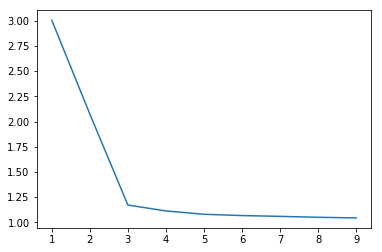

In [54]:
plt.plot(Ks, score)